In [1]:
# import libriaries
import numpy as np
import matplotlib.pyplot as plt
import random 
import os
from tqdm import tqdm

from matplotlib.ticker import ScalarFormatter
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### setup path and read data

In [2]:
data_folder = "./../autodl-tmp/data_raw_total/"
auxiliary_folder = "./../autodl-tmp/"

In [3]:
data_train_AIRS = np.load(f'{data_folder}/data_train_AIRS.npy')
data_train_FGS = np.load(f"{data_folder}/data_train_FGS.npy")

In [4]:
print(data_train_AIRS.shape)
print(data_train_FGS.shape)

(673, 187, 282, 32)
(673, 187, 32, 32)


In [5]:
output_dir = "./../autodl-tmp/outputs/"

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ./../autodl-tmp/outputs/ already exists.


### 1D-CNN for mean transit depth

In [6]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)

targets = train_solution[:,1:]

# used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
targets_mean = targets[:,1:].mean(axis = 1) 
# the number of planets
N = targets.shape[0]

combine the two datasets

In [7]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train_AIRS, data_train_FGS

# compress the width of FGS image
FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2)

# concatenate the two data along the width axis
dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)

In [8]:
# sum up the pixels along the height axis to transform the data into 2D images (times*wavelengths)
dataset = dataset.sum(axis=3)

divide the images by the star flux assuming the first and last 50 instants belong to the out of transit

In [9]:
# normalize two datasets
def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2

# normalize the signal by star spectrum
def norm_star_spectrum (signal) : 
    # extract the mean spectrum of the star
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    # signal is divided by mean star spectrum to avoid the influence of star
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset) 
dataset_norm = np.transpose(dataset_norm,(0,2,1)) # [CHUNK_SIZE, N_wavelengths, N_times]

split the observations and targets between training and validation sets

In [10]:
cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
l = cut_sup - cut_inf + 1 
wls = np.arange(l)

# split the data
def split (data, N) : 
    # select N_train index of planets from the dataset randomly
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1] # training data
    data_2 = data[~list_index_1] # validation data
    return data_1, data_2, list_index_1

# training size
N_train = 8*N//10

# train and validation data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

normalize the training and validation data

In [11]:
# compress the height axis
signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3)
# compute the mean of time and then the mean of wavelength
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
# 1. get the white curve by computing the sum of all wavelengths
# 2. divide the whole mean to normalize the white curve
white_curve = signal_AIRS_diff_transposed_binned.sum(axis=2) / wc_mean[:, np.newaxis]

# min-max normalize
def normalise_wlc(train, valid) :
    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    
    return train_norm, valid_norm

# min-max normalization
def normalize (train, valid) : 
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

# split the light curves and targets 
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]
 
# normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)


Through the above step: 
- observation: every planet has a white curve 
- target: the mean of the planet light curve

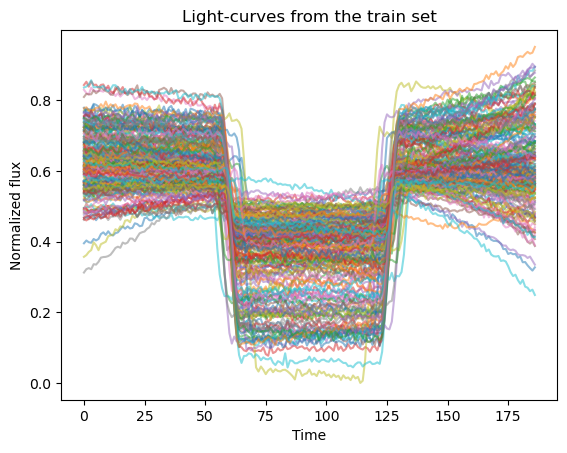

In [12]:
plt.figure()
for i in range (200) : 
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set') 
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

train 1D CNN 

The model to estimate the mean of the target spectrum using the white light-curve is a 1D-CNN with Dropout layers to make a MC Dropout prediction.

In [16]:
# load data
train_dataset = TensorDataset(torch.tensor(train_wc), torch.tensor(train_targets_wc_norm))
valid_dataset = TensorDataset(torch.tensor(valid_wc), torch.tensor(valid_targets_wc_norm))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# define model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.batch_norm1 = nn.BatchNorm1d(num_features=32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm1d(num_features=64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm1d(num_features=128)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm1d(num_features=256)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 9, 500)  # 9 is from the output of the last pooling layer
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 100)
        self.dropout2 = nn.Dropout(0.1)
        self.output = nn.Linear(100, 1)  # Output layer

    def forward(self, x):
        x = self.conv1(x)  # (batch_size, 32, 185)
        x = nn.ReLU()(x)
        x = self.pool(x)   # (batch_size, 32, 92)
        x = self.batch_norm1(x)

        x = self.conv2(x)  # (batch_size, 64, 90)
        x = nn.ReLU()(x)
        x = self.pool(x)   # (batch_size, 64, 45)
        x = self.batch_norm2(x)

        x = self.conv3(x)  # (batch_size, 128, 43)
        x = nn.ReLU()(x)
        x = self.pool(x)   # (batch_size, 128, 21)
        x = self.batch_norm3(x)

        x = self.conv4(x)  # (batch_size, 256, 19)
        x = nn.ReLU()(x)
        x = self.pool(x)   # (batch_size, 256, 9)
        x = self.batch_norm4(x)

        x = self.flatten(x) # Flatten to (batch_size, 256 * 9)
        x = self.fc1(x)     # Fully connected layer
        x = nn.ReLU()(x)
        x = self.dropout1(x) # Dropout
        x = self.fc2(x)     # Fully connected layer
        x = nn.ReLU()(x)
        x = self.dropout2(x) # Dropout
        x = self.output(x)  # Output layer
        
        return x
    
model_wc = CNN1D()

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model_wc.parameters(), lr=0.001)

# adjust learning rate
def scheduler(optimizer, epoch):
    decay_rate = 0.2
    decay_step = 200
    if epoch % decay_step == 0 and epoch > 0:
        optimizer.param_groups[0]['lr'] *= decay_rate
    return optimizer

In [14]:
# training
num_epochs = 1200
train_loss_his = []
valid_loss_his = []

for epoch in tqdm(range(num_epochs)):
    model_wc.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float() 
        optimizer.zero_grad()
        outputs = model_wc(inputs.unsqueeze(1))  # add channel dimension?
        loss = criterion(outputs, targets.unsqueeze(1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    optimizer = scheduler(optimizer, epoch)
    train_loss_his.append(train_loss / len(train_loader))

    # validation
    model_wc.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in valid_loader:
            inputs = inputs.float()
            targets = targets.float() 
            outputs = model_wc(inputs.unsqueeze(1))
            val_loss += criterion(outputs, targets.unsqueeze(1)).item()
    
    val_loss /= len(valid_loader)
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

    # save the best model
    if epoch == 0 or val_loss < min(valid_loss_his):
        torch.save(model_wc.state_dict(), f"{output_dir}models/model_1dcnn.pth")
        print(f"save epoch {epoch+1} model")
    valid_loss_his.append(val_loss)


  0%|          | 1/1200 [00:00<06:33,  3.04it/s]

save epoch 1 model


  0%|          | 2/1200 [00:00<05:29,  3.63it/s]

save epoch 2 model


  0%|          | 3/1200 [00:00<05:08,  3.88it/s]

save epoch 3 model


  0%|          | 4/1200 [00:01<05:06,  3.91it/s]

save epoch 4 model


  0%|          | 5/1200 [00:01<05:01,  3.96it/s]

save epoch 5 model


  0%|          | 6/1200 [00:01<04:58,  4.01it/s]

save epoch 6 model


  1%|          | 7/1200 [00:01<04:51,  4.09it/s]

save epoch 7 model


  1%|          | 8/1200 [00:02<05:01,  3.96it/s]

save epoch 8 model


  1%|          | 9/1200 [00:02<05:04,  3.91it/s]

save epoch 9 model


  1%|          | 11/1200 [00:02<05:00,  3.96it/s]

save epoch 11 model


  1%|          | 13/1200 [00:03<05:01,  3.94it/s]

save epoch 13 model


  2%|▏         | 20/1200 [00:05<05:20,  3.68it/s]

save epoch 20 model


  2%|▏         | 21/1200 [00:05<05:26,  3.62it/s]

save epoch 21 model


  2%|▏         | 26/1200 [00:06<05:32,  3.53it/s]

save epoch 26 model


  3%|▎         | 33/1200 [00:08<05:27,  3.56it/s]

save epoch 33 model


  4%|▎         | 44/1200 [00:11<04:52,  3.95it/s]

save epoch 44 model


  4%|▍         | 54/1200 [00:14<04:35,  4.16it/s]

save epoch 54 model


  6%|▌         | 67/1200 [00:17<04:44,  3.98it/s]

save epoch 67 model


  8%|▊         | 102/1200 [00:25<04:25,  4.13it/s]

save epoch 102 model


 12%|█▏        | 147/1200 [00:36<04:14,  4.13it/s]

save epoch 147 model


 13%|█▎        | 153/1200 [00:38<04:11,  4.17it/s]

save epoch 153 model


 72%|███████▏  | 859/1200 [03:26<01:19,  4.28it/s]

save epoch 859 model


100%|██████████| 1200/1200 [04:46<00:00,  4.18it/s]


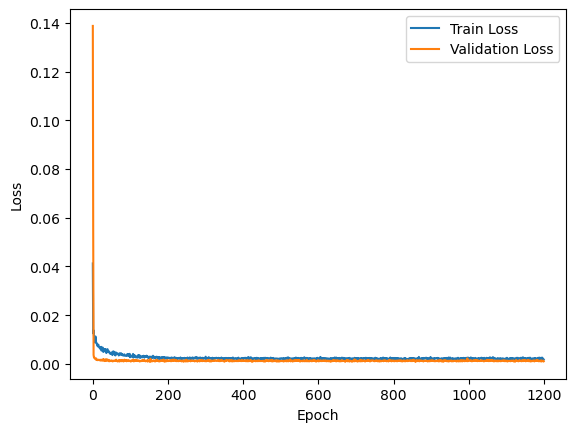

In [15]:
# plot the loss curve
plt.plot(train_loss_his, label='Train Loss')
plt.plot(valid_loss_his, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

perform MC dropout to obtain the mean prediction and the uncertainty associated. 

In [13]:
print(valid_wc.shape)
print(train_wc.shape)

(135, 187)
(538, 187)


In [14]:
# test_wc = np.concatenate([train_wc, valid_wc], axis=0)
# test_wc.shape

(673, 187)

In [17]:
# model_wc = CNN1D()
# model_wc.load_state_dict(torch.load(f"{output_dir}models/model_1dcnn.pth"))

/tmp/ipykernel_1187/3075718318.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_wc.load_state_dict(torch.load(f"{output_dir}models/model_1dcnn.pth"))


<All keys matched successfully>

In [19]:
nb_dropout_wc = 1000 # predict 1000 times

# unstandardize the data
def unstandardizing(data, min_train_valid, max_train_valid):
    return data * (max_train_valid - min_train_valid) + min_train_valid

# conduct Monte Carlo Dropout prediction
def MC_dropout_WC(model, data, nb_dropout):
    data = torch.tensor(data, dtype=torch.float32)
    model.train() # set train mode
    predictions = torch.zeros(nb_dropout, data.size(0)) # store prediction results

    with torch.no_grad():
        for i in range(nb_dropout):
            output = model(data.unsqueeze(1))  # predict
            predictions[i, :] = output.flatten()

    return predictions

if do_the_mcdropout_wc:
    print('Running ...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc.numpy(), min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc = spectre_valid_wc_all.mean(axis=0)
    spectre_valid_std_wc = spectre_valid_wc_all.std(axis=0)
    print('Done.')
else:
    model_wc.eval()
    with torch.no_grad():
        spectre_valid_wc = model_wc(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc.numpy(), min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1 * np.abs(spectre_valid_wc)


Running ...
Done.


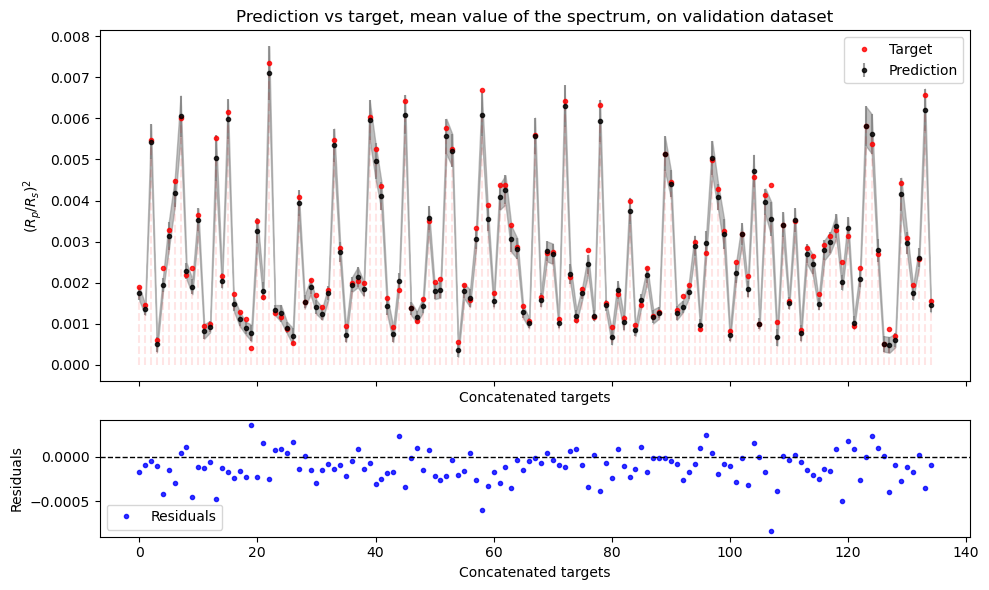

In [18]:
# residual = prediction - target
residuals = spectre_valid_wc - valid_targets_wc

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})
# plot the purview of error
ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
# plot the purview of standard deviation
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

# residuals plot
ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
# residuals = target - prediction
residuals = valid_targets_wc - spectre_valid_wc
# calculate RMSE
print('RMSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm') #（ppm，parts per million）

RMSE :  209.13237472936976 ppm


In [20]:
np.save(f'{output_dir}/pred_valid_wc.npy', spectre_valid_wc)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc.npy', spectre_valid_std_wc)

### 2D CNN for atmospheric features
remove the mean value (transit depth) of the spectra to keep the atmospheric features only

In [23]:
# leave the atmospheric features only
def suppress_mean(targets, mean) : 
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res

# let target be atmospheric features only
train_targets_shift = suppress_mean(train_targets,  targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets,  targets_mean[~list_index_train])

In [24]:
# normalization of the targets - max abs normalization
def targets_normalization (data1, data2) : 
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back (data, data_abs_max) : 
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)

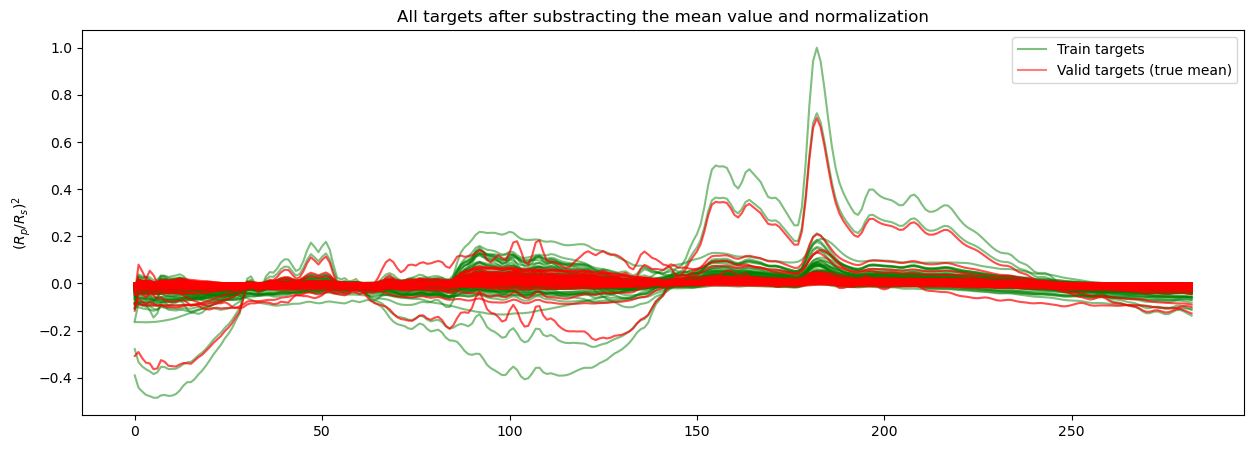

In [25]:
# visualize target distribution
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) : 
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('All targets after substracting the mean value and normalization')
plt.show()

In [26]:
train_obs = train_obs.transpose(0, 2, 1) # [CHUNK_SIZE, N_wavelengths, N_times] -> [CHUNK_SIZE, N_times, N_wavelengths]]
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


cut the transit to keep the in-transit only. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

In [27]:
# substracting the out transit signal
def suppress_out_transit (data, ingress, egress) : 
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

remove the mean value of the in-transit to get relative data like the targets

In [28]:
# Substract the mean
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)

In [29]:
# normalize the dataset - max abs normalization
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])  
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) : 
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)

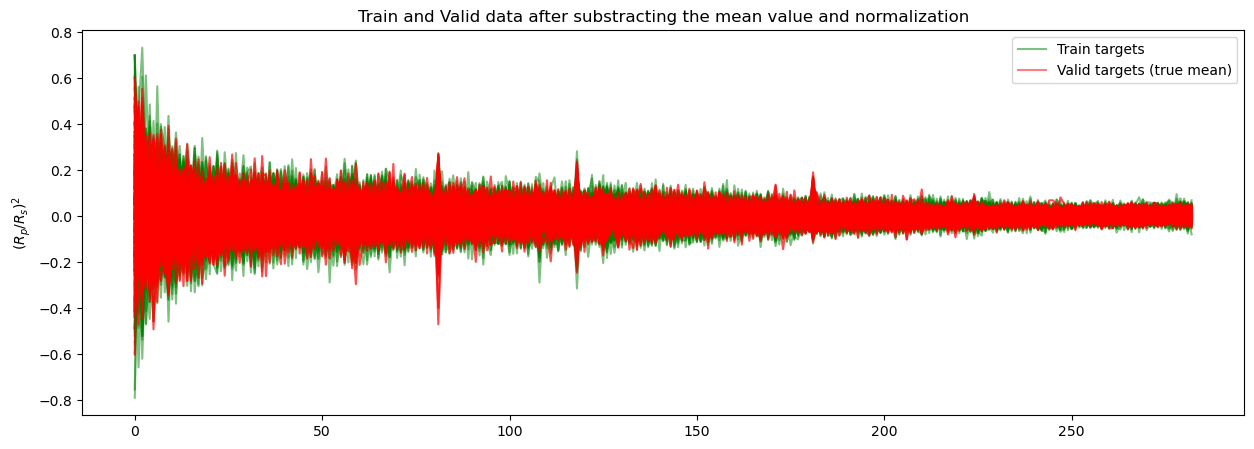

In [30]:
# visualize the training and validation data
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (valid_obs.shape[0]) : 
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()

train 2D CNN

2D CNN is used to extract features from the spectrum and predict atmospheric features that have been substracted by mean.

In [31]:
# Load data
train_dataset = TensorDataset(torch.tensor(train_obs_norm), torch.tensor(train_targets_norm))
valid_dataset = TensorDataset(torch.tensor(valid_obs_norm), torch.tensor(valid_targets_norm))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define the model
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1), padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1), padding='same')
        self.batch_norm2 = nn.BatchNorm2d(num_features=64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 1), padding='same')
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 1), padding='same')
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 3), padding='same')
        self.batch_norm3 = nn.BatchNorm2d(num_features=32)
        
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 3), padding='same')
        
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 3), padding='same')
        
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 3), padding='same')

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 17 * 5, 700)  # Output size after convolutions
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(700, 283)  # Output size matches input width

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)
        x = self.batch_norm2(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool1(x)

        x = self.conv4(x)
        x = nn.ReLU()(x)

        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = self.batch_norm3(x)

        x = self.conv6(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.conv7(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.conv8(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.output(x)

        return x

model = CNN2D()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Model training
num_epochs = 200
train_loss_his = []
valid_loss_his = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add channel dimension
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss_his.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in valid_loader:
            inputs = inputs.float()
            targets = targets.float()
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs, targets).item()
    
    val_loss /= len(valid_loader)
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

    # Save the best model
    if epoch == 0 or val_loss < min(valid_loss_his):
        torch.save(model.state_dict(), f"{output_dir}models/model_2dcnn.pth")
        print(f"Saved model at epoch {epoch + 1}")
    valid_loss_his.append(val_loss)

  0%|          | 1/200 [00:08<27:28,  8.28s/it]

Saved model at epoch 1


  1%|          | 2/200 [00:15<24:48,  7.52s/it]

Saved model at epoch 2


  2%|▏         | 3/200 [00:22<24:04,  7.33s/it]

Saved model at epoch 3


  2%|▎         | 5/200 [00:37<23:51,  7.34s/it]

Saved model at epoch 5


  3%|▎         | 6/200 [00:44<23:31,  7.27s/it]

Saved model at epoch 6


  4%|▎         | 7/200 [00:51<23:27,  7.29s/it]

Saved model at epoch 7


  4%|▍         | 8/200 [00:58<22:56,  7.17s/it]

Saved model at epoch 8


  4%|▍         | 9/200 [01:05<22:43,  7.14s/it]

Saved model at epoch 9


  5%|▌         | 10/200 [01:13<23:16,  7.35s/it]

Saved model at epoch 10


  6%|▌         | 11/200 [01:20<23:06,  7.34s/it]

Saved model at epoch 11


  7%|▋         | 14/200 [01:43<23:11,  7.48s/it]

Saved model at epoch 14


  8%|▊         | 16/200 [01:58<22:51,  7.45s/it]

Saved model at epoch 16


  8%|▊         | 17/200 [02:05<22:22,  7.34s/it]

Saved model at epoch 17


 16%|█▌        | 32/200 [03:53<20:52,  7.46s/it]

Saved model at epoch 32


 16%|█▋        | 33/200 [04:01<20:45,  7.46s/it]

Saved model at epoch 33


 20%|█▉        | 39/200 [04:44<19:16,  7.18s/it]

Saved model at epoch 39


 20%|██        | 40/200 [04:52<19:37,  7.36s/it]

Saved model at epoch 40


 26%|██▌       | 51/200 [06:16<18:41,  7.52s/it]

Saved model at epoch 51


 44%|████▎     | 87/200 [10:42<14:34,  7.74s/it]

Saved model at epoch 87


 53%|█████▎    | 106/200 [13:08<11:27,  7.31s/it]

Saved model at epoch 106


 92%|█████████▏| 183/200 [22:43<02:06,  7.43s/it]

Saved model at epoch 183


 92%|█████████▏| 184/200 [22:50<01:59,  7.48s/it]

Saved model at epoch 184


100%|██████████| 200/200 [24:49<00:00,  7.45s/it]


obtain uncertainties on the predictions by computing a MCDropout

In [33]:
nb_dropout = 5  # the number of MC Dropout

# Compute the uncertainties
def NN_uncertainty(model, x_test, targets_abs_max, T=5):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # Save the predictions
    with torch.no_grad():
        for _ in range(T):
            # Move input to the appropriate device (CPU or GPU)
            x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
            pred_norm = model(x_test_tensor).numpy()  # Make predictions
            pred = targets_norm_back(pred_norm, targets_abs_max)  # Reverse normalization
            predictions.append(pred)  # Store each prediction
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std 


if do_the_mcdropout:
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainty(model, valid_obs_norm, targets_abs_max, T=nb_dropout)
else:
    with torch.no_grad():
        valid_obs_tensor = torch.tensor(valid_obs_norm, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        pred_valid_norm = model(valid_obs_tensor).numpy()
        pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
        spectre_valid_shift = pred_valid
        spectre_valid_shift_std = spectre_valid_shift * 0.1  # Assume uncertainty is 10% of the predicted values


In [34]:
# residuals = target - prediction
residuals = valid_targets_shift - spectre_valid_shift
print('RMSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

RMSE :  33.33388380498087 ppm


In [35]:
np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)

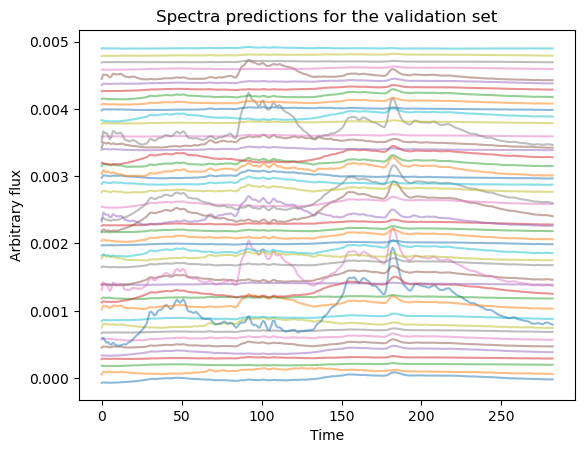

In [36]:
# visualize the predictions on validation set
plt.figure()
for i in range (50) : 
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set') 
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()

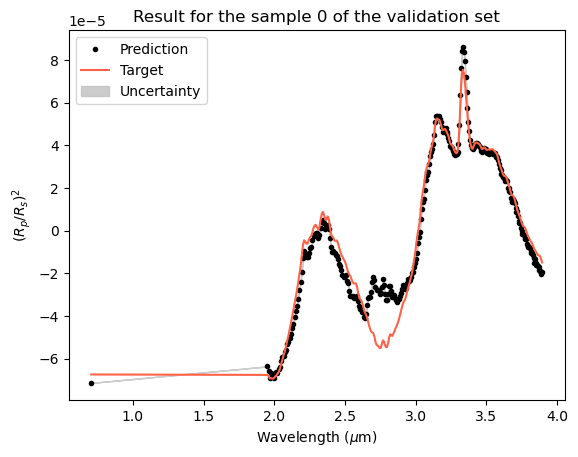

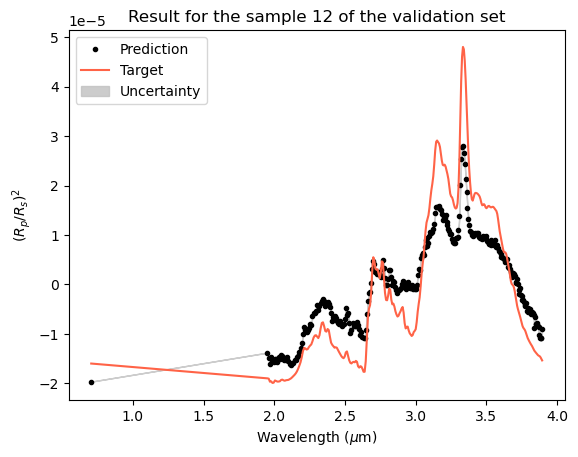

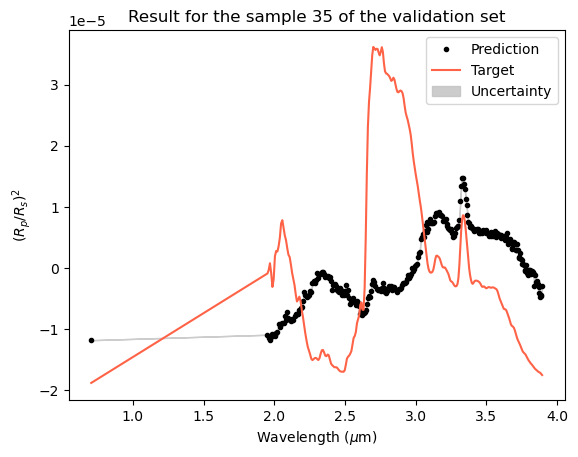

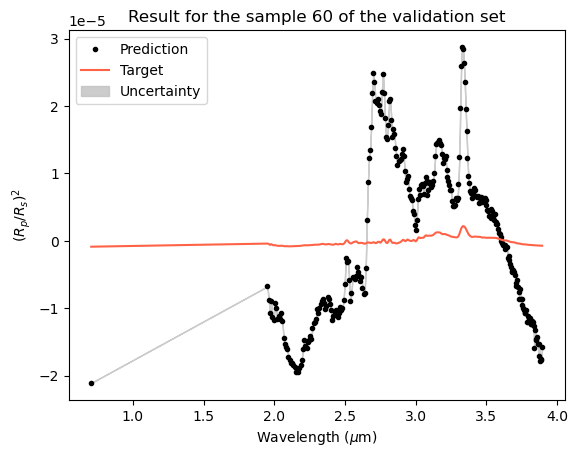

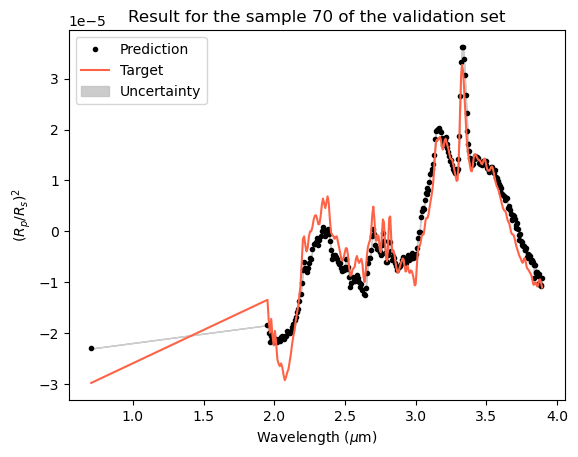

In [37]:
# visualize prediction, target and uncertainty
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt(f'{auxiliary_folder}wavelengths.csv', skiprows=1, delimiter = ',')
uncertainty = spectre_valid_shift_std
for i in (list_valid_planets):
    plt.figure()
    plt.title('Result for the sample {} of the validation set'.format(i))
    plt.plot(wavelength, spectre_valid_shift[i], '.k', label = 'Prediction')
    plt.plot(wavelength, valid_targets_shift[i], color = 'tomato', label = 'Target')
    plt.fill_between(wavelength, spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha = 0.8, label = 'Uncertainty')
    plt.legend()
    plt.ylabel(f'$(R_p/R_s)^2$')
    plt.xlabel(f'Wavelength ($\mu$m)')
    plt.show()

### combine 1D and 2D CNN output for final spectra

In [38]:
def add_the_mean (shift, mean) : 
    '''
    shift: the fluctuation of spectra from 2D CNN (atmospheric features)
    mean: the mean of spectra from 1D CNN (mean transit depth)
    '''
    return shift + mean[:,np.newaxis]

# final prediction
predictions_valid = add_the_mean(spectre_valid_shift, spectre_valid_wc)

# final uncertainty
predictions_std_valid = np.sqrt(spectre_valid_std_wc[:,np.newaxis]**2 + spectre_valid_shift_std**2) 


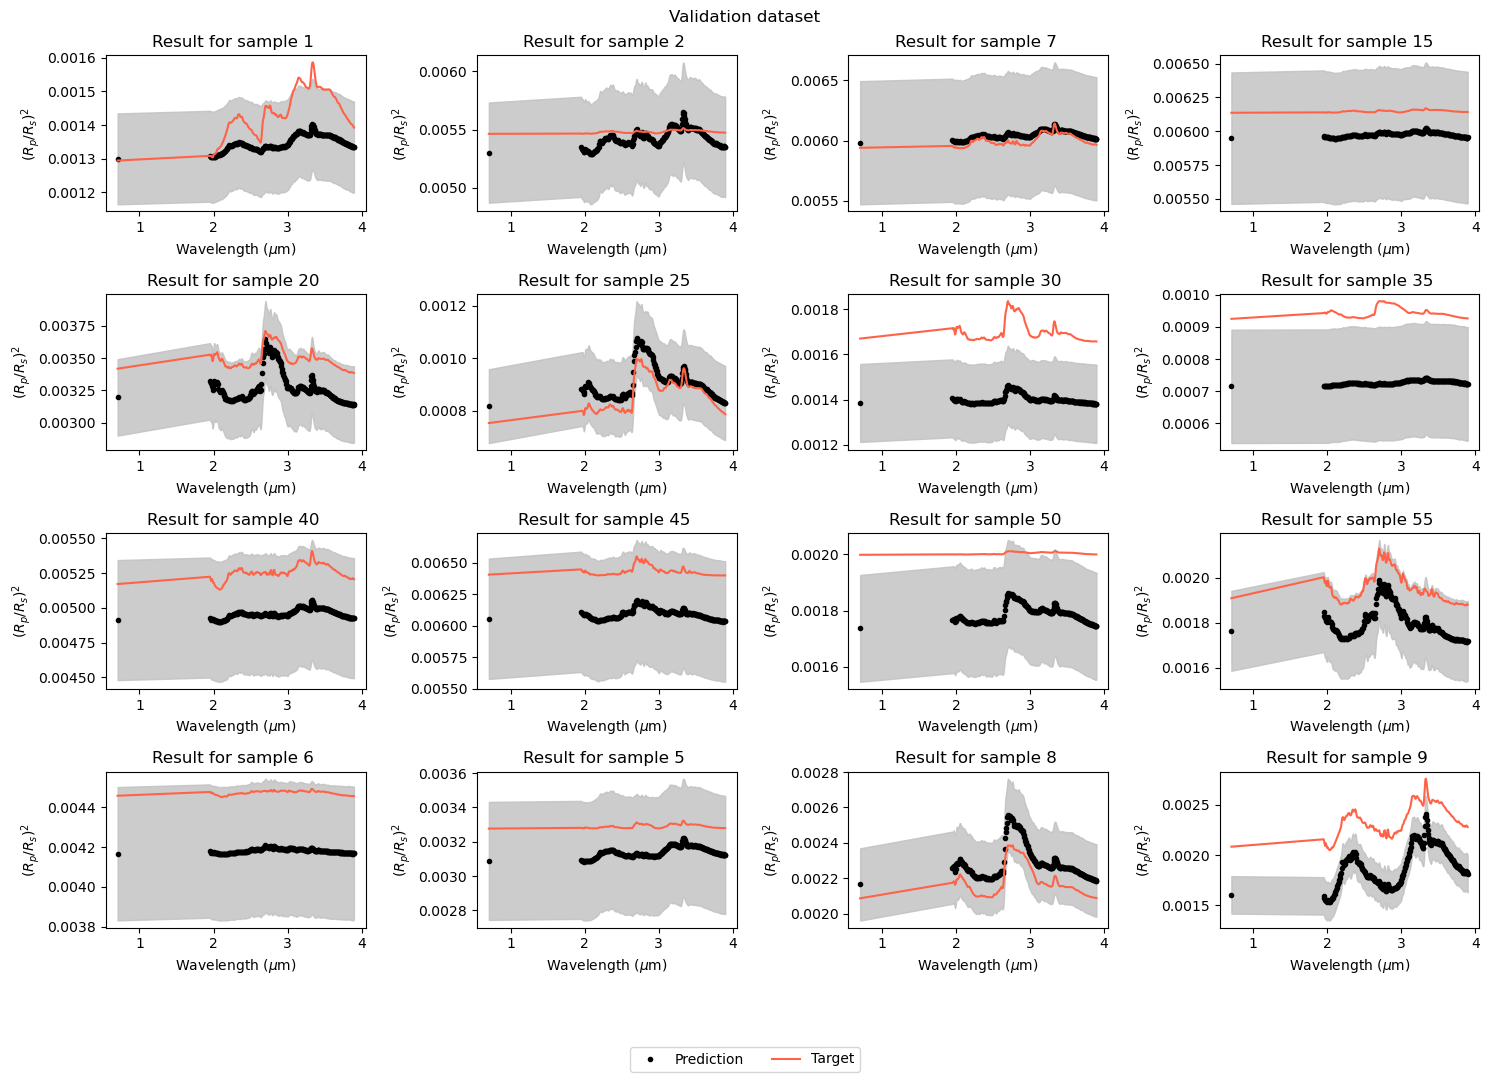

In [39]:
uncertainty = predictions_std_valid

def plot_one_sample_valid(ax, p):
    ax.set_title(f'Result for sample {p} ')
    line1, = ax.plot(wavelength, predictions_valid[p], '.k', label='Prediction')
    line2, = ax.plot(wavelength, valid_targets[p], color='tomato', label='Target')
    ax.fill_between(wavelength, predictions_valid[p, :] - uncertainty[p], predictions_valid[p, :] + uncertainty[p], color='silver', alpha=0.8, label='Uncertainty')
    ax.set_ylabel(f'$(R_p/R_s)^2$')
    ax.set_xlabel(f'Wavelength ($\mu$m)')
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(lines[:2], ['Prediction', 'Target'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle('Validation dataset')
plt.tight_layout()
plt.show()


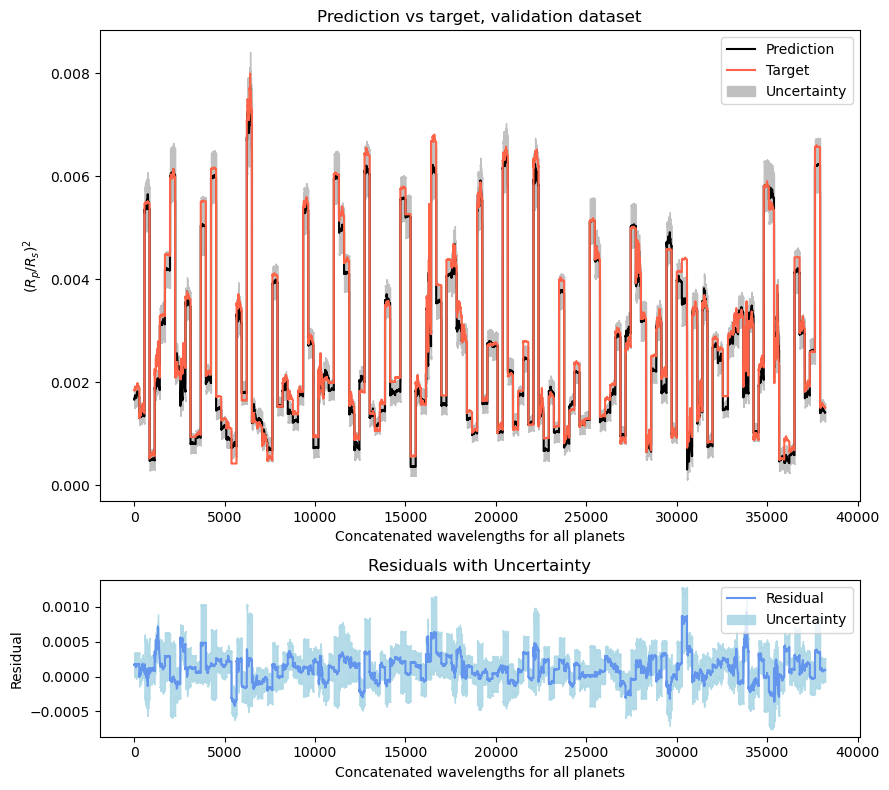

RMSE :  211.6801484068187 ppm


In [40]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0) # concatenate the predictions
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0) # concatenate the targets
spectre_valid_std_concatenated = np.concatenate(std, axis=0) # concatenate the uncertainty of the predictions
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})


axs[0].plot(wls_concatenated, predictions_concatenated_plot, '-', color='k', label="Prediction")
axs[0].plot(wls_concatenated, targets_concatenated_plot, '-', color='tomato', label="Target")
axs[0].fill_between(np.arange(len(wls_concatenated)), 
                    predictions_concatenated_plot - uncertainty, 
                    predictions_concatenated_plot + uncertainty, 
                    color='silver', alpha=1, label='Uncertainty')
axs[0].set_xlabel('Concatenated wavelengths for all planets')
axs[0].set_ylabel(f'$(R_p/R_s)^2$')
axs[0].set_title('Prediction vs target, validation dataset')
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, '-', color='cornflowerblue', label="Residual")
axs[1].fill_between(np.arange(len(wls_concatenated)), 
                    residuals - uncertainty, 
                    residuals + uncertainty, 
                    color='lightblue', alpha=0.9, label='Uncertainty')
axs[1].set_xlabel('Concatenated wavelengths for all planets')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residuals with Uncertainty')
axs[1].legend()

plt.tight_layout()
plt.show()

print('RMSE : ',np.sqrt((residuals**2).mean())*1e6, 'ppm')

In [41]:
np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)